In [1]:
from GraphSampler import GraphSample
import  collections
from random import choice
import math
from collections import Counter
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import time
from scipy.stats import ks_2samp


In [257]:
def degree_hist(g):
    degree_sequence = sorted([d for n, d in g.degree()], reverse=True)  # degree sequence
    # print "Degree sequence", degree_sequence
    degreeCount = collections.Counter(degree_sequence)
    # returns degree, count
    return zip(*degreeCount.items())

In [261]:
g = nx.powerlaw_cluster_graph(200000,10,0.1)

In [266]:
nodes, edges = GraphSample().list_sampling(g,target_size=0.0001)
g_sample = nx.Graph()
g_sample.add_nodes_from(nodes)
g_sample.add_edges_from(edges)

In [264]:
nodes_gmd, edges_gmd, eps = GraphSample().gmd(g,target_size=0.1, C= 71)

In [265]:
nodes_rcmh, edges_rcmh = GraphSample().rcmhrw(g,target_size = 0.1, alpha= 0.1)

In [271]:
sampler = GraphSample()
c = nx.algorithms.average_clustering(g_sample)
print(c)
c1 = sampler.avg_clustering_gmd(g, nodes_gmd, eps, 0)
print(c1)
c2 = sampler.avg_clustering_rcmh(g,nodes_rcmh,0.1)
print(c2)

0.024340286350332422
0.019260648934547
0.017362474086165435


In [268]:
rcmh_subgraph = g.subgraph(nodes_rcmh)

In [2]:
web = nx.read_edgelist("data/web-BerkStan.txt")

In [3]:
print(len(web.nodes))
# should be 685230
print(len(web.edges))
# should be 7600595

685230
6649470


In [34]:
experiment_result = pd.DataFrame(columns=["percentage","n","avg_clustering","degrees","run",
                                          "time_sample","time_clust"])
print(experiment_result)

Empty DataFrame
Columns: [percentage, n, avg_clustering, degrees, run, time_sample, time_clust]
Index: []


In [103]:
def run_experiment(graph, start_n,finish_n,step_n, runs_per_n):
    experiment_result = pd.DataFrame(columns=["percentage","n","avg_clustering","degrees","run",
                                          "time_sample","time_clust"])
    sampler = GraphSample()
    for n in range(start_n*1000,finish_n*1000,step_n*1000):
        print("n %s" % n)
        for run in range(0,runs_per_n):
            print("run %s" % run)
            
            time_sample_start = time.time()
            nodes_gmd, edges_gmd, eps = GraphSample().gmd(graph,target_size=n/1000, C= 71)
            time_sample = time.time() - time_sample_start
            time_sample = float('%.2f' % time_sample)
            
            nodes = len(nodes_gmd)
            
            time_clust_start = time.time()
            clustering = sampler.avg_clustering_gmd(graph,nodes_gmd,eps,71)
            time_clust = time.time() - time_clust_start
            time_clust = float('%.2f' % time_clust)
            
            degrees = web.degree(nbunch=nodes_gmd)
            experiment_result = experiment_result.append({"percentage":n,"n":nodes,"avg_clustering":clustering,
                                      "degrees":degrees,"run":run,"C":71,
                                      "time_sample":time_sample,"time_clust":time_clust}, ignore_index=True)
    return experiment_result


n 1
run 0
n 2
run 0
n 3
run 0
n 4
run 0
n 5
run 0


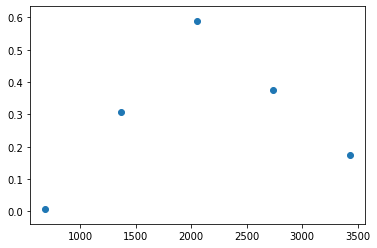

In [109]:
%matplotlib inline
plt.scatter(experiment_result["n"],abs(0.59-experiment_result["avg_clustering"]))

In [ ]:
g = nx.powerlaw_cluster_graph(200,10,0.1)
nodes, edges = GraphSample().list_sampling(g,target_size=0.0001)
g_sample = nx.Graph()
g_sample.add_nodes_from(nodes)
g_sample.add_edges_from(edges)

In [13]:
def run_experiment_web(graph):
    experiment_result = pd.DataFrame(columns=["percentage","avg_clustering","degrees",
                                              "alg","C","alpha","m","time_sample","time_clust","V"])
    sampler = GraphSample()
    for n in range(1,2):
        print("n %s" % n)
        target_size = n/100
        
        C = 71
        alpha = 0.2
        time_sample_start = time.time()
        nodes, edges = GraphSample().list_sampling(graph,target_size=target_size, V2=True)
        time_sample = time.time() - time_sample_start
        time_sample = float('%.2f' % time_sample)
        
        g_sample = nx.Graph()
        g_sample.add_nodes_from(nodes)
        g_sample.add_edges_from(edges)
        time_clust_start = time.time()
        list_clust = nx.average_clustering(g_sample)
        time_clust = time.time() - time_clust_start
        time_clust = float('%.2f' % time_clust)
        
        experiment_result = experiment_result.append({"percentage":target_size,"avg_clustering":list_clust,
                                  "degrees":nx.degree(g_sample),"alg":"list","time_sample":time_sample,
                                                      "time_clust":time_clust,"V":2},ignore_index=True)
        
        time_sample_start = time.time()
        nodes_gmd, edges_gmd, eps = GraphSample().gmd(graph,target_size=target_size, C=C)
        time_sample = time.time() - time_sample_start
        time_sample = float('%.2f' % time_sample)
        
        time_clust_start = time.time()
        gmd_clust = sampler.avg_clustering_gmd(graph,nodes_gmd,eps,C)
        time_clust = time.time() - time_clust_start
        time_clust = float('%.2f' % time_clust)
        
        experiment_result = experiment_result.append({"percentage":target_size,"avg_clustering":gmd_clust,
                                  "degrees":nx.degree(graph,nodes_gmd),"alg":"gmd","time_sample":time_sample,
                                   "time_clust":time_clust, "C":C},ignore_index=True)
            
        time_sample_start = time.time()
        nodes_rcmh, edges_rcmh = GraphSample().rcmhrw(graph,target_size = target_size, alpha= alpha)
        time_sample = time.time() - time_sample_start
        time_sample = float('%.2f' % time_sample)
        
        time_clust_start = time.time()
        rcmh_clust = sampler.avg_clustering_rcmh(graph,nodes_rcmh,alpha)
        time_clust = time.time() - time_clust_start
        time_clust = float('%.2f' % time_clust)
                    
        experiment_result = experiment_result.append({"percentage":target_size,"avg_clustering":rcmh_clust,
                                  "degrees":nx.degree(graph,nodes_rcmh),"alg":"rcmh","time_sample":time_sample,
                                    "time_clust":time_clust,"alpha":alpha},ignore_index=True)
    
    return experiment_result

In [14]:
def run_ba(m_list,target_size,C, alpha):
    sampler = GraphSample()
    experiment_result = pd.DataFrame(columns=["percentage","avg_clustering","degrees",
                                              "true_clust","alg","C","alpha","m","true_degree","V"])
    for m in m_list:
        print(m)
        g = nx.barabasi_albert_graph(5000,m, seed = 0)
        true_clust = nx.average_clustering(g)
        for run in range(5):
         
            nodes, edges = GraphSample().list_sampling(g,target_size=target_size)
            g_sample = nx.Graph()
            g_sample.add_nodes_from(nodes)
            g_sample.add_edges_from(edges)
            list_clust = nx.average_clustering(g_sample)
            experiment_result = experiment_result.append({"percentage":target_size,"avg_clustering":list_clust,
                                      "degrees":nx.degree(g_sample),"true_clust":true_clust,
                                      "alg":"list","m":m,"true_degree":nx.degree(g),"V":1},ignore_index=True)
            nodes, edges = GraphSample().list_sampling(g,target_size=target_size, V2=True)
            g_sample = nx.Graph()
            g_sample.add_nodes_from(nodes)
            g_sample.add_edges_from(edges)
            list_clust = nx.average_clustering(g_sample)
            experiment_result = experiment_result.append({"percentage":target_size,"avg_clustering":list_clust,
                                      "degrees":nx.degree(g_sample),"true_clust":true_clust,
                                      "alg":"list","m":m,"true_degree":nx.degree(g),"V":2},ignore_index=True)
            
            nodes_gmd, edges_gmd, eps = GraphSample().gmd(g,target_size=target_size, C= C)
            gmd_clust = sampler.avg_clustering_gmd(g,nodes_gmd,eps,C)
            experiment_result = experiment_result.append({"percentage":target_size,"avg_clustering":gmd_clust,
                                      "degrees":nx.degree(g,nodes_gmd),"true_clust":true_clust,
                                      "alg":"gmd", "C": C,"m":m,"true_degree":nx.degree(g)},ignore_index=True)    
            nodes_rcmh, edges_rcmh = GraphSample().rcmhrw(g,target_size = target_size, alpha= alpha)
            rcmh_clust = sampler.avg_clustering_rcmh(g,nodes_rcmh,alpha)
            experiment_result = experiment_result.append({"percentage":target_size,"avg_clustering":rcmh_clust,
                                      "degrees":nx.degree(g,nodes_rcmh),"true_clust":true_clust,
                                      "alg":"rcmh", "alpha": alpha,"m":m,"true_degree":nx.degree(g)},ignore_index=True)    
    return experiment_result           

In [15]:
def run_gnp(m_list,target_size):
    sampler = GraphSample()
    experiment_result = pd.DataFrame(columns=["percentage","avg_clustering","degrees",
                                              "true_clust","alg","C","alpha","p","true_degree","V"])
    for p in m_list:
        
        print(p)
        g = nx.gnp_random_graph(5000,p, seed = 0)
        true_clust = nx.average_clustering(g)
         
        nodes, edges = GraphSample().list_sampling(g,target_size=target_size)
        g_sample = nx.Graph()
        g_sample.add_nodes_from(nodes)
        g_sample.add_edges_from(edges)
        list_clust = nx.average_clustering(g_sample)
        experiment_result = experiment_result.append({"percentage":target_size,"avg_clustering":list_clust,
                                      "degrees":nx.degree(g_sample),"true_clust":true_clust,
                                      "alg":"list","p":p,"true_degree":nx.degree(g), "V":1},ignore_index=True)
        nodes, edges = GraphSample().list_sampling(g,target_size=target_size, V2=True)
        g_sample = nx.Graph()
        g_sample.add_nodes_from(nodes)
        g_sample.add_edges_from(edges)
        list_clust = nx.average_clustering(g_sample)
        experiment_result = experiment_result.append({"percentage":target_size,"avg_clustering":list_clust,
                                      "degrees":nx.degree(g_sample),"true_clust":true_clust,
                                      "alg":"list","p":p,"true_degree":nx.degree(g), "V":2},ignore_index=True)
        for run in range(6):
            c_options = {0:0,1:30,2:50,3:70,4:100,5:150}
            C = c_options[run]
            nodes_gmd, edges_gmd, eps = GraphSample().gmd(g,target_size=target_size, C= C)
            gmd_clust = sampler.avg_clustering_gmd(g,nodes_gmd,eps,C)
            experiment_result = experiment_result.append({"percentage":target_size,"avg_clustering":gmd_clust,
                                      "degrees":nx.degree(g,nodes_gmd),"true_clust":true_clust,
                                      "alg":"gmd", "C": C,"p":p,"true_degree":nx.degree(g)},ignore_index=True)
            alpha_options = {0:0,1:0.2,2:0.4,3:0.6,4:0.8,5:1}
            alpha = alpha_options[run]
            
            nodes_rcmh, edges_rcmh = GraphSample().rcmhrw(g,target_size = target_size, alpha= alpha)
            rcmh_clust = sampler.avg_clustering_rcmh(g,nodes_rcmh,alpha)
            experiment_result = experiment_result.append({"percentage":target_size,"avg_clustering":rcmh_clust,
                                      "degrees":nx.degree(g,nodes_rcmh),"true_clust":true_clust,
                                      "alg":"rcmh", "alpha": alpha,"p":p,"true_degree":nx.degree(g)},ignore_index=True)    
    return experiment_result

In [16]:
experiment_result = run_ba([1,26,75,250,500],0.1,71,0.1)
experiment_result.to_csv("results/barabasi.csv")

1
26
75
250
500


In [17]:
experiment_result = run_gnp([0.01,0.05,0.1],0.1)
experiment_result.to_csv("results/gnp.csv")

0.01
0.05
0.1


In [18]:
experiment_result = run_gnp([0.01,0.05,0.1],0.01)
experiment_result.to_csv("results/gnp_smaller_sample.csv")

0.01
0.05
0.1


In [19]:
web = nx.read_edgelist("data/web-BerkStan.txt")
experiment_result = run_experiment_web(web)
experiment_result.to_csv("results/web.csv")

n 1


In [6]:
def convert_degree(entry):
    temp = entry.replace("(","")
    temp = temp.replace(")","")
    temp = temp.replace("[","")
    temp = temp.replace("]","")
    temp = temp.replace(" ","")
    temp = temp.split(",")
    temp = list(map(int,temp))
    final_true  = list()
    for x in range(0,len(temp),2):
        final_true.append((temp[x],temp[x+1]))
    return(final_true)

In [61]:
results_web = pd.read_csv("results/web.csv")

In [62]:
results_web.loc[2]

Unnamed: 0                                                        2
percentage                                                     0.01
avg_clustering                                              0.43833
degrees           [('648652', 2), ('648654', 3), ('648652', 2), ...
alg                                                            rcmh
C                                                               NaN
alpha                                                           0.2
m                                                               NaN
time_sample                                                    3.19
time_clust                                                    190.6
V                                                               NaN
Name: 2, dtype: object

In [63]:
#true_degree = convert_degree(results_web.loc[2]["true_degree"]) 
#deg = [x[1] for x in true_degree]
#plt.hist([x for x in deg], alpha=0.5, label='x', density=True, log =True)
true_degree = convert_degree(results_web.loc[2]["degrees"]) 
deg = [x[1] for x in true_degree]
plt.hist([x for x in deg], alpha=0.5, label='y', density=True, log =True)
plt.xlabel("Degree")
plt.ylabel("Count (log scale)")

ValueError: invalid literal for int() with base 10: "'648652'"

In [64]:
print(int('648652'))

648652


In [2]:
results = pd.read_csv("results/barabasi.csv")


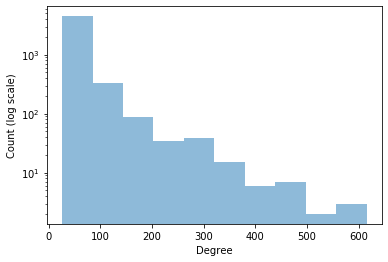

In [89]:
true_degree = convert_degree(results.loc[20]["true_degree"]) 
deg = [x[1] for x in true_degree]
plt.hist([x for x in deg], alpha=0.5, label='x', log=True)
plt.xlabel("Degree")
plt.ylabel("Count (log scale)")
plt.savefig("BA_model_h1.png")

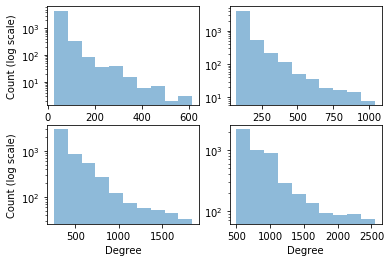

In [98]:
fig = plt.figure()

plt.subplot(2, 2, 1)
true_degree = convert_degree(results.loc[20]["true_degree"]) 
deg = [x[1] for x in true_degree]
plt.hist([x for x in deg], alpha=0.5, label='x', log=True)
#plt.xlabel("Degree")
plt.ylabel("Count (log scale)")

plt.subplot(2, 2, 2)
true_degree = convert_degree(results.loc[30]["true_degree"]) 
deg = [x[1] for x in true_degree]
plt.hist([x for x in deg], alpha=0.5, label='x', log=True)
#plt.xlabel("Degree")
#plt.ylabel("Count (log scale)")

plt.subplot(2, 2, 3)
true_degree = convert_degree(results.loc[50]["true_degree"]) 
deg = [x[1] for x in true_degree]
plt.hist([x for x in deg], alpha=0.5, label='x', log=True)
plt.xlabel("Degree")
plt.ylabel("Count (log scale)")

plt.subplot(2, 2, 4)
true_degree = convert_degree(results.loc[60]["true_degree"]) 
deg = [x[1] for x in true_degree]
plt.hist([x for x in deg], alpha=0.5, label='x', log=True)
plt.xlabel("Degree")
#plt.ylabel("Count (log scale)")
plt.savefig("H1_hists.png")
plt.show()

Text(0, 0.5, 'Count (log scale)')

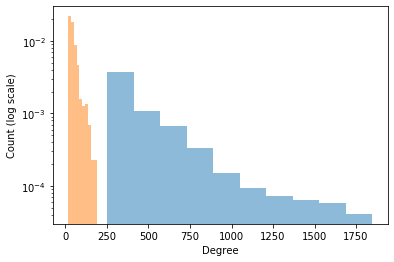

In [47]:
true_degree = convert_degree(results.loc[61]["true_degree"]) 
deg = [x[1] for x in true_degree]
plt.hist([x for x in deg], alpha=0.5, label='x', density=True, log =True)
true_degree = convert_degree(results.loc[61]["degrees"]) 
deg = [x[1] for x in true_degree]
plt.hist([x for x in deg], alpha=0.5, label='y', density=True, log =True)
plt.xlabel("Degree")
plt.ylabel("Count (log scale)")
#plt.savefig("BA_model_h1.png")

In [24]:
results.loc[61]["V"]

2.0

In [31]:
list2_results = results[(results["alg"]=="list") & (results["V"]==2)]
list1_results = results[(results["alg"]=="list") & (results["V"]==1)]
rcmh_results = results[results["alg"]=="rcmh"]
gmd_results = results[results["alg"]=="gmd"]

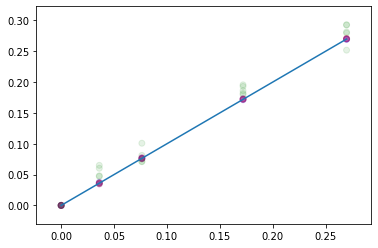

In [7]:
# They are all fairly exact but list algorithm seems to have higher variablity 
colors = {'rcmh':'red', 'gmd':'blue', 'list':'green'}
plt.scatter(results["true_clust"], results["avg_clustering"], c = results["alg"].apply(lambda x: colors[x]), alpha=0.1)
plt.plot(results["true_clust"],results["true_clust"])

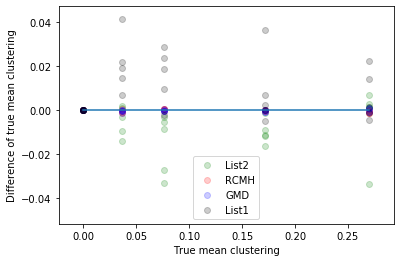

In [38]:
# variability much better seen for green
#plt.scatter(results["true_clust"], results["avg_clustering"]-results["true_clust"], c = results["alg"].apply(lambda x: colors[x]), alpha=0.1)
plt.scatter(list2_results["true_clust"], list2_results["avg_clustering"]-list2_results["true_clust"], 
            c = "green", alpha=0.2,label="List2")
plt.scatter(rcmh_results["true_clust"], rcmh_results["avg_clustering"]-rcmh_results["true_clust"], 
            c = "red", alpha=0.2, label="RCMH")
plt.scatter(gmd_results["true_clust"], gmd_results["avg_clustering"]-gmd_results["true_clust"], 
            c = "blue", alpha=0.2, label ="GMD")
plt.scatter(list1_results["true_clust"], list1_results["avg_clustering"]-list1_results["true_clust"], 
            c = "black", alpha=0.2,label="List1")


plt.legend(loc="lower center")
plt.plot(results["true_clust"],results["true_clust"]-results["true_clust"])
plt.ylabel("Difference of true mean clustering")
plt.xlabel("True mean clustering")
plt.savefig("diff_true_mean_BA.png")

In [22]:
results.shape[0]

75

In [8]:
def obtain_ks_results(results):
    ks_results = pd.DataFrame(columns=["m","alg","statistics","p-value", "V"])
    
    for i in range(0,results.shape[0]):
        print(i)
        g = nx.barabasi_albert_graph(5000,results.loc[i]["m"], seed = 0)
        true_degree = convert_degree(results.loc[i]["true_degree"]) 
        true_degree = [x[1] for x in true_degree]
        sampled_degree = convert_degree(results.loc[i]["degrees"]) 
        if(results.loc[i]["alg"]=="list"):
            sampled_degree = [nx.degree(g,x[0]) for x in sampled_degree]
        else:
            sampled_degree = [x[1] for x in sampled_degree]
            
        ks_test = ks_2samp(true_degree,sampled_degree)
        ks_results = ks_results.append({"m":results.loc[i]["m"],"alg":results.loc[i]["alg"],
                           "statistics":ks_test[0],"p-value":ks_test[1], "V":results.loc[i]["V"]}, ignore_index=True)    
    return(ks_results)

In [9]:
results.loc[1]["m"]

1

In [10]:
#results = pd.read_csv("results/barabasi.csv")
#g = nx.gnp_random_graph(5000,results.loc[1]["p"], seed = 0)
ks_results = obtain_ks_results(results)
print(ks_results.head())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
   m   alg  statistics       p-value    V
0  1  list    0.070998  1.828759e-02  1.0
1  1  list    0.015219  9.998664e-01  2.0
2  1   gmd    0.345000  2.034197e-47  NaN
3  1  rcmh    0.335000  9.842887e-45  NaN
4  1  list    0.082036  3.862011e-03  1.0


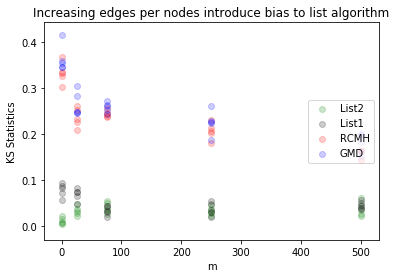

In [11]:
plt.scatter(ks_results[(ks_results["alg"]=="list") & (ks_results["V"]==2)]["m"], 
            ks_results[(ks_results["alg"]=="list") & (ks_results["V"]==2)]["statistics"], 
            c = "green", alpha=0.2,label="List2")
plt.scatter(ks_results[(ks_results["alg"]=="list") & (ks_results["V"]==1)]["m"], 
            ks_results[(ks_results["alg"]=="list") & (ks_results["V"]==1)]["statistics"], 
            c = "black", alpha=0.2,label="List1")
plt.scatter(ks_results[ks_results["alg"]=="rcmh"]["m"], ks_results[ks_results["alg"]=="rcmh"]["statistics"], 
            c = "red", alpha=0.2, label="RCMH")
plt.scatter(ks_results[ks_results["alg"]=="gmd"]["m"], ks_results[ks_results["alg"]=="gmd"]["statistics"], 
            c = "blue", alpha=0.2, label ="GMD")
plt.legend(loc="right")
plt.ylabel("KS Statistics")
plt.xlabel("m")
plt.title("Increasing edges per nodes introduce bias to list algorithm")
plt.savefig("KS.png")

In [48]:
results_gnp = pd.read_csv("results/gnp.csv")

In [70]:
results_gnp.loc[1]["p"]

0.01

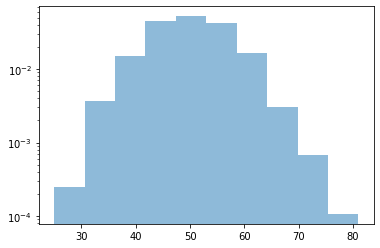

In [ ]:
g = nx.gnp_random_graph(5000,results_gnp.loc[1]["p"], seed = 0)

In [76]:
true_degree = convert_degree(results_gnp.loc[1]["degrees"]) 
node = [nx.degree(g,x[0]) for x in true_degree]
print(node)

[57, 54, 43, 54, 61, 55, 47, 39, 69, 62, 43, 45, 59, 51, 51, 44, 53, 44, 51, 63, 51, 48, 45, 48, 42, 50, 47, 51, 48, 32, 54, 49, 44, 41, 53, 49, 52, 50, 55, 55, 52, 51, 42, 51, 43, 49, 49, 56, 61, 69, 44, 53, 52, 40, 52, 55, 42, 51, 60, 52, 49, 50, 45, 48, 54, 47, 54, 51, 57, 53, 52, 46, 45, 59, 62, 63, 48, 59, 37, 52, 61, 43, 62, 47, 49, 36, 46, 53, 47, 57, 48, 50, 56, 39, 42, 64, 44, 44, 53, 61, 51, 57, 46, 43, 41, 50, 43, 48, 56, 50, 61, 42, 41, 54, 41, 59, 47, 51, 45, 46, 44, 58, 46, 45, 56, 57, 60, 50, 52, 48, 49, 49, 51, 56, 53, 49, 45, 49, 49, 48, 64, 48, 46, 53, 48, 50, 47, 42, 51, 45, 41, 51, 56, 49, 58, 53, 42, 61, 55, 42, 53, 57, 52, 56, 51, 63, 45, 45, 48, 56, 60, 59, 42, 49, 47, 45, 47, 50, 43, 51, 48, 50, 44, 50, 60, 62, 45, 48, 43, 53, 53, 38, 46, 49, 55, 48, 56, 58, 49, 40, 49, 45, 37, 52, 57, 48, 62, 43, 47, 48, 37, 55, 52, 44, 46, 49, 39, 50, 52, 52, 45, 51, 49, 47, 58, 38, 48, 49, 48, 57, 46, 63, 62, 61, 59, 58, 45, 56, 58, 51, 41, 39, 52, 36, 54, 53, 57, 51, 46, 49,

Text(0, 0.5, 'Count (log scale)')

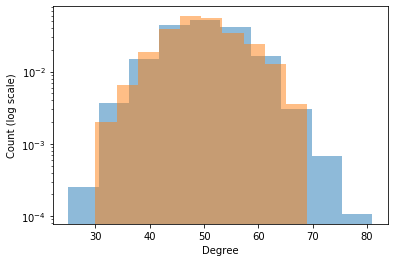

In [77]:
true_degree = convert_degree(results_gnp.loc[1]["true_degree"]) 
deg = [x[1] for x in true_degree]
plt.hist([x for x in deg], alpha=0.5, label='x', density=True, log =True)
plt.hist(node, alpha=0.5, label='y', density=True, log =True)
plt.xlabel("Degree")
plt.ylabel("Count (log scale)")


In [ ]:
# next steps: change alpha and sample size and measure avg clustering and degree distribution
# next steps: change C and sample size and measure avg clustering and degree distribution
# next steps: measure the time the different algorithms take to complete with change in degree distribution and alpha 
# (could be that it gets rejected a lot and takes a long time to finish)
# next steps: quantify variability of list algorithm
